# Naver Blog 수집 및 시각화.
- 20180620 ver. 도메인 주소 파싱 수정

In [ ]:
from selenium import webdriver
from selenium.common.exceptions import NoSuchElementException

In [ ]:
from urllib.parse import quote_plus
from urllib.parse import urlparse
from sklearn.feature_extraction.text import CountVectorizer
from sys import platform

import json
import time
import os
import lxml.html
import numpy
import operator
import re
import requests


from konlpy.tag import Komoran
tagger = Komoran()

In [ ]:
# browser execute
if platform == "linux" or platform == "linux2":
    browser=webdriver.Chrome(executable_path='./chromedriver')
elif platform == "darwin":
    browser=webdriver.Chrome(executable_path='./chromedriver')
elif platform == "win32":
    browser=webdriver.Chrome(executable_path='./chromedriver.exe')


In [ ]:
search_url = ('https://section.blog.naver.com/Search/Post.nhn?pageNo={page}&rangeType=ALL&orderBy=sim&keyword={query}')
query = quote_plus('')

post_links = []

# range(1, 3) 에서 3를 원하는 페이지 만큼 수정
for page in range(1, 3):
    url = search_url.format(query=query, page=page)
    browser.get(url)
    browser.implicitly_wait(2)
    time.sleep(2)
    # 모든 블로그 주소가 들어가 있는 부분 검색
    posts_lists = browser.find_elements_by_css_selector('a.desc_inner')


    for post_list in posts_lists:
        print(post_list.get_attribute('href')) # 주소 보기(2가지 유형)
        post_links.append(post_list.get_attribute('href'))


## url 목록에서 검색용 blogId와 logNo 구하기

In [ ]:
post_urls = []
p = re.compile("https://\w+\.blog\.me/\d+")              # blog.me 도메인 추출

for post_link in post_links:
    m = p.search(post_link)
    if m:                                                # https://id.blog.me/logNo
        website = urlparse(post_link)
        blog_id = website[1].split('.')[-3]
        post_id = website.path[1:]
    elif post_link.startswith('https://blog.naver.com'): # https://blog.naver.com로 시작하는 주소
        website = urlparse(post_link)
        _, blog_id, post_id = website.path.split('/')
    else:                                                # 자기 도메인
        res = requests.get(post_link)
        root = lxml.html.fromstring(res.text)
        blog_url = root.cssselect('frame#screenFrame').pop().attrib['src']
        website = urlparse(blog_url)
        _, blog_id, post_id = website.path.split('/')


    # 위 주소로 불러오면 파싱이 안되며 아래주소로 변경하고 불러야 파싱이 된다.
    post_url = 'http://blog.naver.com/PostView.nhn?blogId={}&logNo={}'.format(blog_id, post_id)
    post_urls.append(post_url)
#     print(post_link, blog_id, post_id, post_url)
post_urls

In [ ]:
posts = []

for post_url in post_urls:
    try:
        print(post_url)
        browser.get(post_url)
        time.sleep(1)
    #     browser.implicitly_wait(4)
        post_result = browser.find_element_by_css_selector('div.se_component_wrap.sect_dsc.__se_component_area')
        posts.append(post_result.text)
    except NoSuchElementException: # smart editor 3.0이전 작성 자료
        if not browser.find_elements_by_css_selector('div#error_content'): # "페이지를 찾을 수 없습니다." 페이지가 아니면 예전 방식으로 파싱
            post_result = browser.find_element_by_css_selector('div.post-view')
            posts.append(post_result.text)
    except:
        continue

browser.close()

In [ ]:
def get_noun(text):
    nouns = tagger.nouns(text)
    return [n for n in nouns if len(n) > 1]

cv = CountVectorizer(tokenizer=get_noun, max_features = 100)

tdm = cv.fit_transform(posts)

In [ ]:
posts

In [10]:
words = cv.get_feature_names()

count_mat= tdm.sum(axis=0)
count = numpy.squeeze(numpy.asarray(count_mat))
word_count = list(zip(words, count))
word_count = sorted(word_count, key = operator.itemgetter(1), reverse=True)

In [ ]:
word_count 

In [ ]:
%matplotlib inline

In [ ]:
from matplotlib import pyplot
from wordcloud import WordCloud

# font_paths는 윈도우의 경우 C:\\Windows\\Fonts\\malgun.ttf 로 변경
wc = WordCloud(font_path='/Library/Fonts/NanumGothic.ttf', background_color='white', width=1600, height=800)
cloud = wc.generate_from_frequencies(dict(word_count))

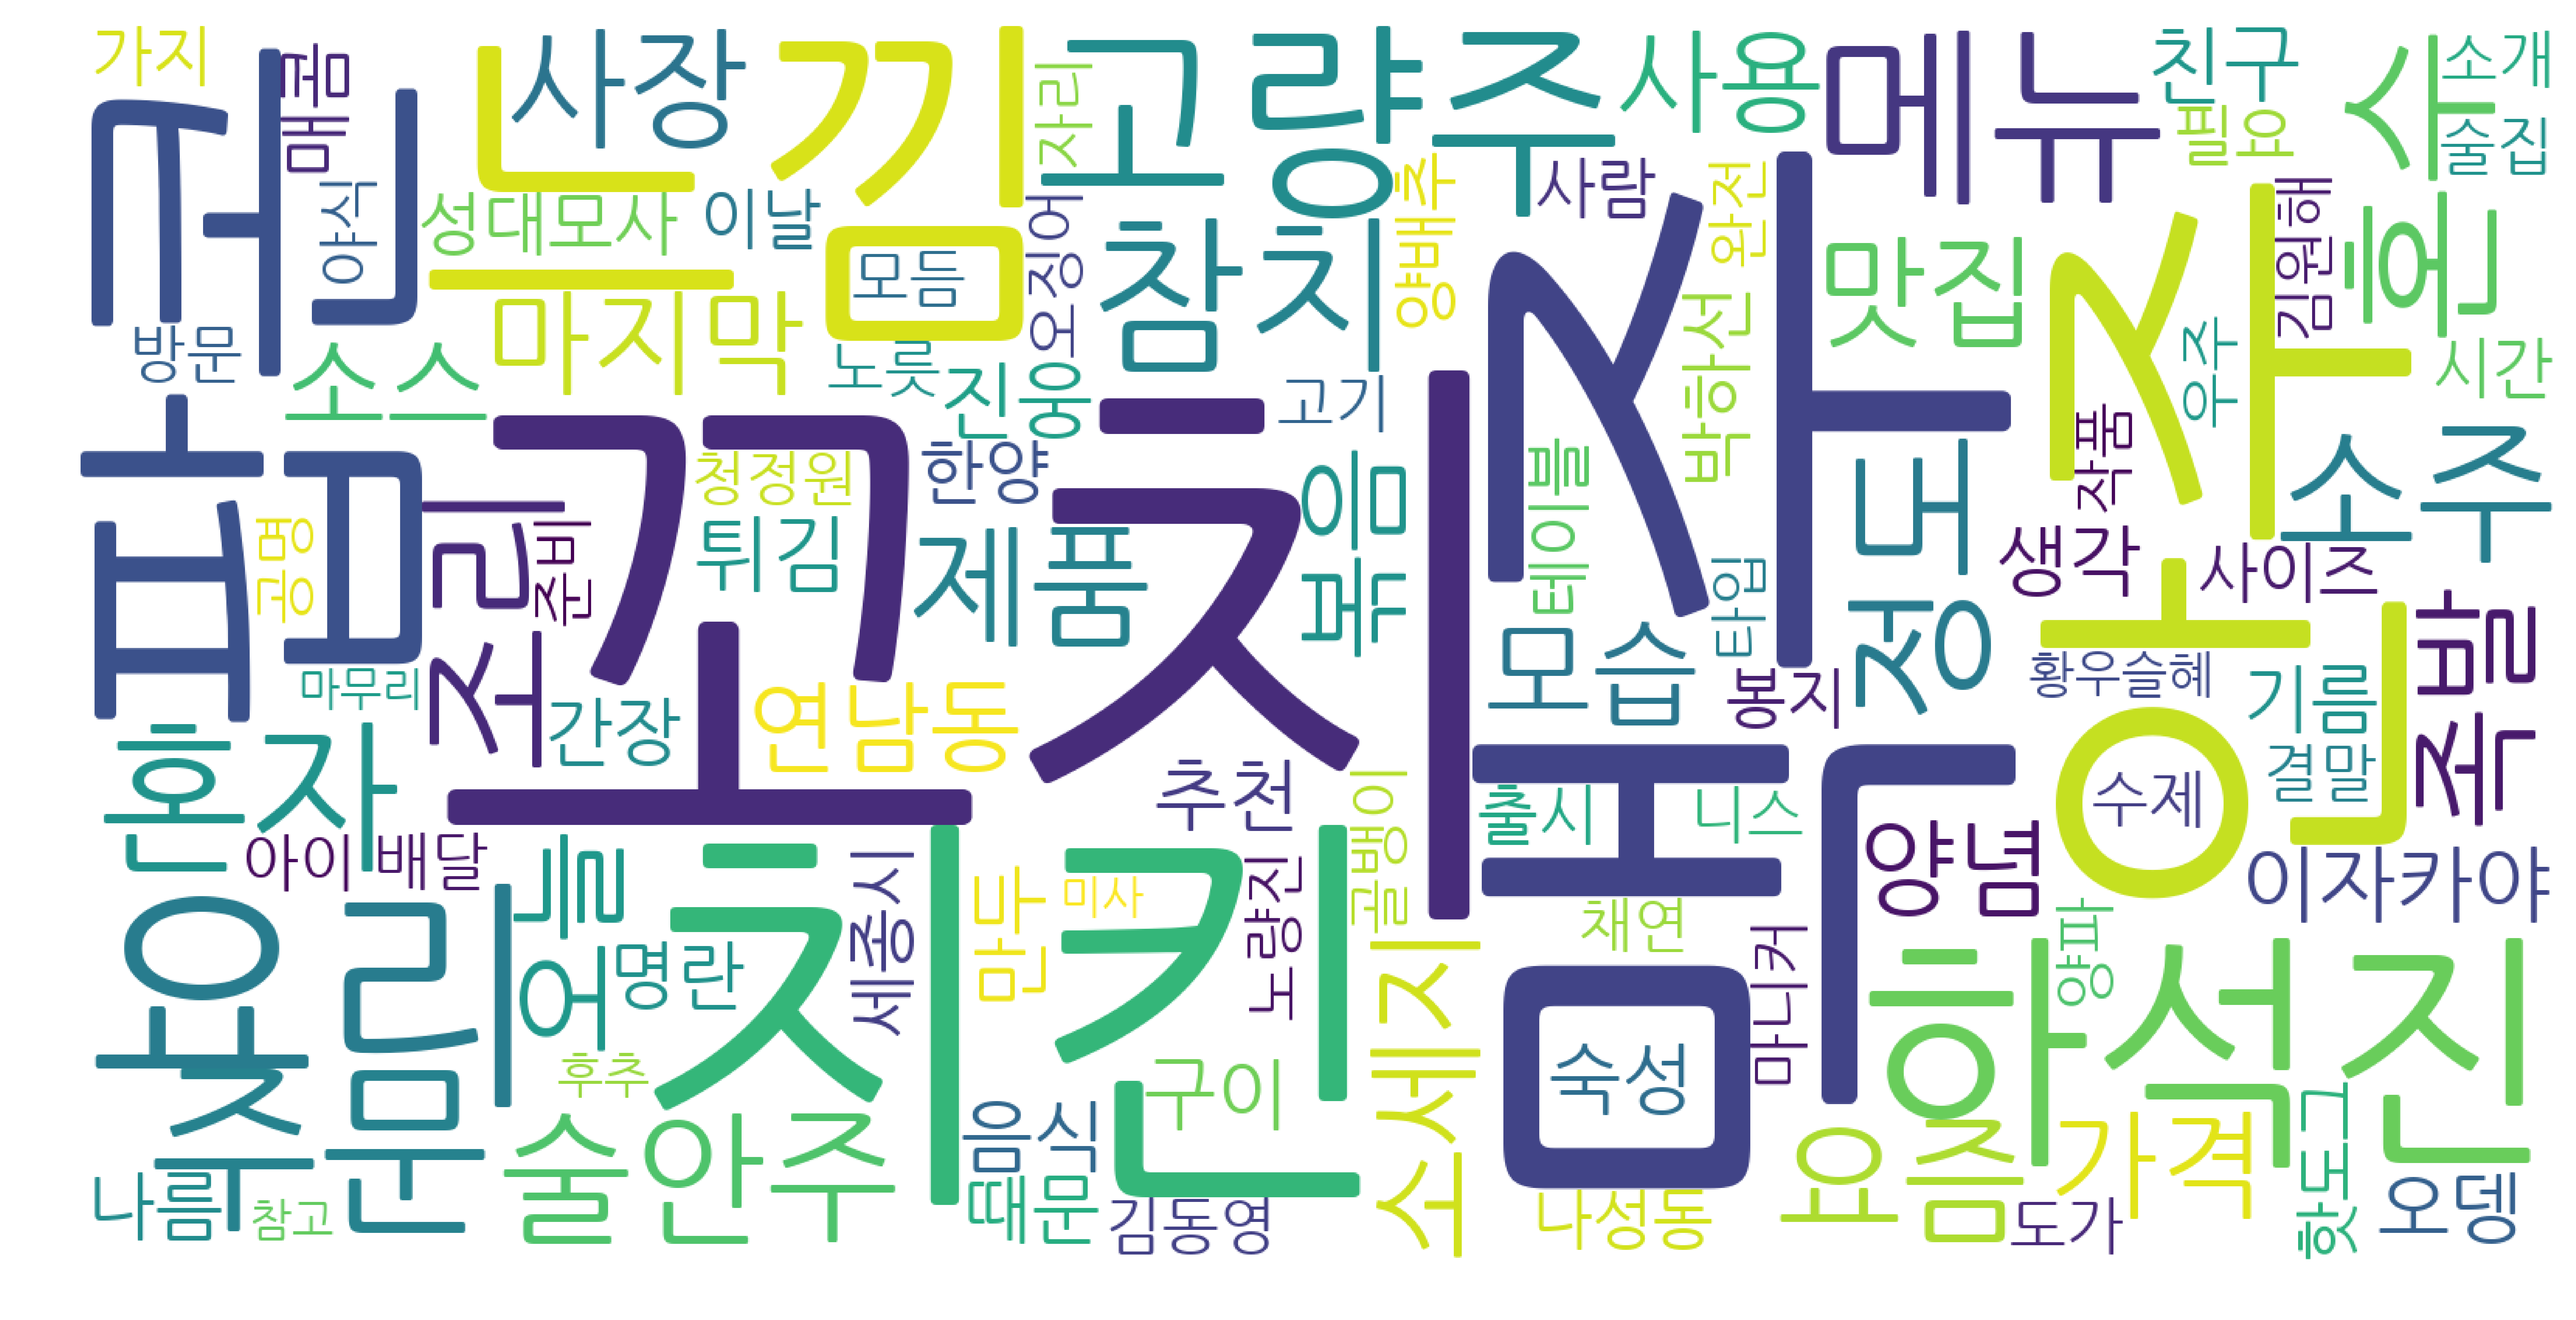

In [28]:
pyplot.figure(figsize=(20,10), dpi=600)
pyplot.imshow(cloud)
pyplot.axis("off")
pyplot.show()